# 공통사항

## Import Library

In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

## Data Load

In [2]:
train_path = '../../data/train.csv'
test_path  = '../../data/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

## Data Preprocessing

In [3]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
# 데이터를 동일하게 처리해주기 유용함.
dt['is_test'] = 0
dt_test['is_test'] = 1
df = pd.concat([dt, dt_test])     # 하나의 데이터로 만들어줍니다.

In [4]:
# 필요 없어 보이는 columns 제거
drop_col = ['부번', '계약일', 'k-전화번호', 'k-팩스번호', 'k-관리방식', 'k-복도유형', 'k-시행사', 'k-사용검사일-사용승인일', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일', 'k-관리비부과면적', '주차대수', '건축면적', '해제사유발생일', '단지소개기존clob', 'k-135㎡초과', '중개사소재지', '등기신청일자']
df.drop(drop_col, axis=1, inplace=True)

In [5]:
df['구'] = df['시군구'].apply(lambda x:x.split()[1])
df['동'] = df['시군구'].apply(lambda x:x.split()[2])

omg = ['용산구', '강남구', '서초구', '송파구', '성동구', '종로구']
is_omg = []
for x in df['구'].tolist():
    if x in omg:
        is_omg.append(1)
    else:
        is_omg.append(0)
df['개비싸'] = is_omg
# 이렇게 말고 '동' 을 분류하지 않아도 될듯       
df.loc[~df['구'].isin(omg), '동'] = 'Unknown' 

del df['시군구']

In [6]:
# 위 처럼 아무 의미도 갖지 않는 칼럼은 결측치와 같은 역할을 하므로, np.nan으로 채워 결측치로 인식되도록 합니다.
df['거래유형'] = df['거래유형'].replace('-', np.nan)

In [7]:
# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
df['본번'] = df['본번'].astype('str')

In [8]:
df['계약년'] = df['계약년월'].astype('str').map(lambda x : x[:4])
df['계약월'] = df['계약년월'].astype('str').map(lambda x : x[4:])

In [9]:
# 'time_col' 데이터를 문자열 형태로 변환
df['계약년월'] = df['계약년월'].astype(str)
# 문자열 형태 데이터를 datetime 형태로 변환
df['계약년월'] = pd.to_datetime(df['계약년월'], format='%Y%m')
# 변환 확인
print(df['계약년월'].head())

0   2017-12-01
1   2017-12-01
2   2017-12-01
3   2018-01-01
4   2018-01-01
Name: 계약년월, dtype: datetime64[ns]


In [10]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적(㎡)', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '좌표X', '좌표Y', 'target', 'is_test', '개비싸']
범주형 변수: ['번지', '본번', '아파트명', '계약년월', '도로명', '거래유형', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-난방방식', 'k-건설사(시공사)', '구', '동', '계약년', '계약월']


In [11]:
# 수치형 데이터를 어떻게 채워야 될지 모르겠음 -> 걍 빼.
# 좌표X, 좌표Y 를 리니어로 채우는건 혼동을 줄 수 있는 데이터임
df.drop(columns=['k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '좌표X', '좌표Y'], inplace=True)

In [12]:
# 범주형 변수에 대한 보간
df[categorical_columns] = df[categorical_columns].fillna('NULL')

## Feature engineering

In [13]:
df_train = df.loc[df['is_test']==0, :]
df_test = df.loc[df['is_test']==1, :]

df_train.drop(['is_test'], axis=1, inplace=True)
df_test.drop(['is_test'], axis=1, inplace=True)
print(df_train.shape, df_test.shape)

(1118822, 19) (9272, 19)


In [14]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
df_test['target'] = 0

In [15]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in df_train.columns:
    if column == '계약년월':
        continue
    if pd.api.types.is_numeric_dtype(df_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적(㎡)', '층', '건축년도', 'target', '개비싸']
범주형 변수: ['번지', '본번', '아파트명', '도로명', '거래유형', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-난방방식', 'k-건설사(시공사)', '구', '동', '계약년', '계약월']


In [16]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( df_train[col].astype(str) )
    df_train[col] = lbl.transform(df_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(df_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    df_test[col] = lbl.transform(df_test[col].astype(str))

100%|██████████| 13/13 [00:03<00:00,  3.79it/s]


In [17]:
df_train.head()        # 레이블인코딩이 된 모습입니다.

,번지,본번,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,거래유형,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-난방방식,k-건설사(시공사),target,구,동,개비싸,계약년,계약월
0,4732,1149,328,79.97,2017-12-01,3,1987,6176,0,3,2,1,241,124000.0,0,3,1,10,11
1,4732,1149,328,79.97,2017-12-01,4,1987,6176,0,3,2,1,241,123500.0,0,3,1,10,11
2,4732,1149,328,54.98,2017-12-01,5,1987,6176,0,3,2,1,241,91500.0,0,3,1,10,11
3,4732,1149,328,79.97,2018-01-01,4,1987,6176,0,3,2,1,241,130000.0,0,3,1,11,0
4,4732,1149,328,79.97,2018-01-01,2,1987,6176,0,3,2,1,241,117000.0,0,3,1,11,0


# Model Training

https://gmnam.tistory.com/230

In [18]:
assert df_train.shape[1] == df_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

In [19]:
df_train.head()

,번지,본번,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,거래유형,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-난방방식,k-건설사(시공사),target,구,동,개비싸,계약년,계약월
0,4732,1149,328,79.97,2017-12-01,3,1987,6176,0,3,2,1,241,124000.0,0,3,1,10,11
1,4732,1149,328,79.97,2017-12-01,4,1987,6176,0,3,2,1,241,123500.0,0,3,1,10,11
2,4732,1149,328,54.98,2017-12-01,5,1987,6176,0,3,2,1,241,91500.0,0,3,1,10,11
3,4732,1149,328,79.97,2018-01-01,4,1987,6176,0,3,2,1,241,130000.0,0,3,1,11,0
4,4732,1149,328,79.97,2018-01-01,2,1987,6176,0,3,2,1,241,117000.0,0,3,1,11,0


In [20]:
# 분할된 데이터를 fold별로 시각화하기 위한 함수를 구성합니다.
# Scikit-learn에서 https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html 사용한 코드를 가져와서 사용하겠습니다.
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(x, y, cv, ax, split_strategy='KFold', group=None, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    for ii, (tr, tt) in enumerate(cv.split(X=x, y=y, groups=group)):
        # Fill in indices with the training/test groups
        print(f"Fold {ii} :")
        print(f"  Train : index={tr[:5]}...")
        print(f"  Valid : index={tt[:5]}...")
        indices = np.array([np.nan] * len(x))
        indices[tt] = 1
        indices[tr] = 0
        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=0.2,
        )

    # Formatting
    yticklabels = list(range(5))

    ax.set(
        yticks=np.arange(len(yticklabels)) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[len(yticklabels) + 0.2, -0.2],
        xlim=[0, len(x)],
    )
    ax.set_title(split_strategy, fontsize=15)
    return ax

In [21]:
X_train = df_train.drop(['target'], axis=1)
Y_train = df_train['target']

In [22]:
from sklearn.model_selection import TimeSeriesSplit
# TimeSeriesSplit 함수를 선언합니다.
kf = TimeSeriesSplit(n_splits=5)

In [23]:
# 시간순 정렬을 위해 이전에 저장해두었던 시간정보를 붙입니다.
X_train = X_train.sort_values(by='계약년월') # 시간순으로 정렬합니다.
Y_train = Y_train.reindex(X_train.index) # 정렬된 X_train의 인덱스에 맞추어 Y_train도 정렬해줍니다.

X_train = X_train.reset_index(drop=True) # 인덱스를 재정렬 해줍니다.
Y_train = Y_train.reset_index(drop=True)

In [24]:
X_train

,번지,본번,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,거래유형,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-난방방식,k-건설사(시공사),구,동,개비싸,계약년,계약월
0,404,101,2177,52.460,2007-01-01,5,1981,4783,0,3,2,1,159,23,0,0,0,0
1,4968,1204,6188,84.570,2007-01-01,1,1996,6240,0,0,0,0,73,11,0,0,0,0
2,2347,697,5920,83.475,2007-01-01,7,1988,8918,0,0,0,0,73,11,0,0,0,0
3,2347,697,5920,66.225,2007-01-01,5,1988,8918,0,0,0,0,73,11,0,0,0,0
4,3000,810,506,59.740,2007-01-01,6,1999,3209,0,0,0,0,73,12,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,722,210,777,84.844,2023-06-01,17,2003,5408,1,0,0,0,73,16,0,0,16,5
1118818,4606,1121,5608,59.970,2023-06-01,10,1998,6044,1,0,0,0,73,3,0,0,16,5
1118819,1508,521,2635,59.890,2023-06-01,6,2009,3965,1,3,2,1,253,12,0,0,16,5
1118820,4625,1125,4787,59.990,2023-06-01,15,2004,4251,1,0,0,0,73,16,0,0,16,5


In [25]:
# 계약년월 순서로 잘 정렬되었나 확인
X_train

,번지,본번,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,거래유형,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-난방방식,k-건설사(시공사),구,동,개비싸,계약년,계약월
0,404,101,2177,52.460,2007-01-01,5,1981,4783,0,3,2,1,159,23,0,0,0,0
1,4968,1204,6188,84.570,2007-01-01,1,1996,6240,0,0,0,0,73,11,0,0,0,0
2,2347,697,5920,83.475,2007-01-01,7,1988,8918,0,0,0,0,73,11,0,0,0,0
3,2347,697,5920,66.225,2007-01-01,5,1988,8918,0,0,0,0,73,11,0,0,0,0
4,3000,810,506,59.740,2007-01-01,6,1999,3209,0,0,0,0,73,12,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,722,210,777,84.844,2023-06-01,17,2003,5408,1,0,0,0,73,16,0,0,16,5
1118818,4606,1121,5608,59.970,2023-06-01,10,1998,6044,1,0,0,0,73,3,0,0,16,5
1118819,1508,521,2635,59.890,2023-06-01,6,2009,3965,1,3,2,1,253,12,0,0,16,5
1118820,4625,1125,4787,59.990,2023-06-01,15,2004,4251,1,0,0,0,73,16,0,0,16,5


Fold 0 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[186472 186473 186474 186475 186476]...
Fold 1 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[372942 372943 372944 372945 372946]...
Fold 2 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[559412 559413 559414 559415 559416]...
Fold 3 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[745882 745883 745884 745885 745886]...
Fold 4 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[932352 932353 932354 932355 932356]...


<Axes: title={'center': 'Time-Series K-Fold'}, xlabel='Sample index', ylabel='CV iteration'>

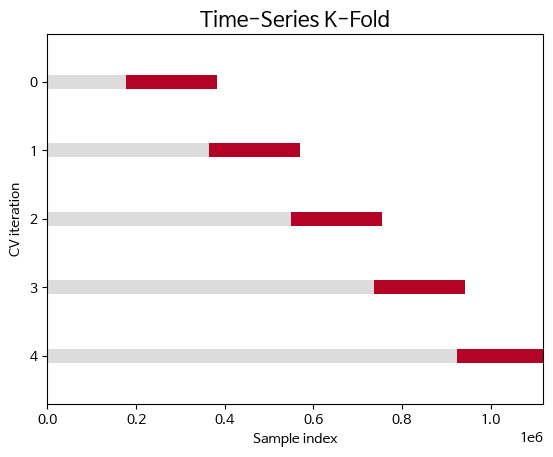

In [27]:
# TimeSeriesSplit를 시각화합니다.
fig, ax = plt.subplots()
plot_cv_indices(x=X_train,
                y=Y_train,
                cv=kf,
                ax=ax,
                split_strategy='Time-Series K-Fold')

In [28]:
# 학습 데이터를 TimeSeriesSplit로 나눕니다.
train_folds = kf.split(X_train, Y_train)
display(train_folds)

<generator object TimeSeriesSplit.split at 0x7f044c6ecdd0>